### Projekt zaliczeniowy na zajęcia Uczenie Maszynowe, Mikołaj Pełszyk

Spis treści:
- Opis źródła danych
- Przygotowanie danych do modelowania i ich eksploracja
- Regresja Logistyczna
- K Najbliższych Sąsiadów
- Las Losowy
- XGBoost
- Podsumowanie

# Źródło danych
Wybrane przeze mnie dane to zbiór opublikowany przez Cleveland Clinic Foundation: https://archive.ics.uci.edu/dataset/45/heart+disease# 
Plik zawiera 14 zmiennych:


1. age - wiek podany w latach
2. sex - płeć (1 = mężczyzna; 0 = kobieta)
3. cp - typ bólu w klatce piersiowej (1 = ból typowy dla dusznicy bolesnej; 2 = nietypowy ból dla dusznicy bolesnej; 3 = ból niezwiazany z dusznicą bolesną; 4 = brak objawów)
4. trestbps - ciśnienie krwi mierzone w spoczynku w mm Hg
5. chol - poziom cholesterolu w surowicy (mg/dl)
6. fbs - czy poziom cukru we krwi na czczo przekracza 120mg/dl (1 - tak; 0 - nie)
7. restecg - wynik EKG w spoczynku (0 = w normie; 1 = zaburzenia - fale ST lub T odchylone o >0.05mV od normy; 2 = Widoczna hipertrofia mięśnia sercowego w EKG)
8. thalach - maksymalne tętno
9. exang - ból w klatce piersiowej spowodowany ćwiczeniami (1 = tak; 0 = nie)
10. oldpeak - obniżenie odcinka ST podczas próby wysiłkowej w porównaniu do spoczynku
11. slope - nachylenie odcinka ST podczas dużego wysiłku (1 = nachylenie w górę odcinka ST; 2 = płaski odcinek ST; 3 = nachylenie w dół odcinka ST)
12. ca - liczba głównych żył pokolorowanych przez fluoroskopię (0-3)
13. thal - talsemia (3 = normalny przeływ krwi; 6 = brak przepływu krwi w niektórych częściach serca; 7 = obserwowany przepływ krwi ale nie jest w normie)
14. num - atrybut decyzyjny - (1,2,3,4) = zdiagnozowana choroba serca, 0 = brak choroby serca 

Zmienna num zostanie zredukowana do problemu binarnego, co sugerują autorzy zbioru.

Na początku przygotowuję wszystkie potrzebne importy, tworzę dataframe z danymi z pliku oraz definiuję później użyte funkcje:

In [2]:
#Wczytanie bibliotek i zrodla danych
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import stat
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
 

# Pobranie danych
data = pd.read_csv('processed.cleveland.data', header=None)

In [3]:
# Pipeline one hot encoder
OHE_pipeline = Pipeline([
    ('OHE', OneHotEncoder()),
])

def calculate_metrics(y_true, y_pred, y_pred_proba=None, name='Model'):
    """
    funkcja liczaca rozne miary jakosci prognozy

    """
    # Policz macierz pomylek i pobierz z niej wartosci
    TN,FP,FN,TP = confusion_matrix(y_true, y_pred).ravel()


    # Policz miary jakosci prognozy
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    NPV = TN / (TN + FN)
    PPV = TP / (TP + FP)
    f1_binary = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    FPR = 1 - specificity

    # Policz tez krzywa ROC jezeli y_pred_proba jest podane
    fpr, tpr, thresholds = [], [], []
    roc_auc = None
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)

    # Zapisz do slownika metrics miary jakosci prognozy
    metrics = {
        'sensitivity': sensitivity,
        'specificity': specificity,
        'NPV': NPV,
        'PPV/precision': PPV,
        'f1_score': f1_binary,
        'accuracy': accuracy,
        'FPR': FPR,
        'roc_auc': roc_auc
    }
    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    metrics_df['model'] = name
    return metrics_df

def plot_roc_curve(y_true, y_pred_proba, name='Model'):
    """
    funkcja sluzaca do szybkiego rysowania krzywej ROC
    """
    # Policz krzywa ROC
    fpr, tpr, thresholds = [], [], []
    roc_auc = None
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)

    #Narysuj krzywa zgodnie z ponizszym wzorcem
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve, AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(y_true, y_pred, labels=None, name='Model'):
    """
    funkcja ktora pozwala szybko narysowac macierz konfuzji/ pomylek
    """
    # Policz macierz pomylek
    cm_values = confusion_matrix(y_true, y_pred)

    # Stworz i narysuj obiekt ConfusionMatrixDisplay z tytulem i opisem osi
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_values, display_labels=labels)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()




def feature_importance(model, X_train):
    """
    funkcja do szybkiego badania feature importance modeli
    """
    # Wez wartosci feature_importances_ z modelu i zapisz ja w dataframe
    feature_importances = model.feature_importances_
    importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    #Posortuj je po od najwiekszej wartosci Importance i zwroc dataframe
    importances_df = importances_df.sort_values(by='Importance', ascending=False)
    importances_df = importances_df.reset_index(drop=True)

    return importances_df

## Przygotowanie danych do modelowania i ich eksploracja

In [108]:
# Przypisuję etykiety kolumn zgodnie z informacjami ze zrodla danych
data.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

# Zgodnie z zaleceniami autorow sprowadzam zmienną objasniana / target / atrybut decyzyjny do problemu binarnego
data['num'] = data['num'].apply(lambda x:0 if x== 0 else 1) 
data.info()
mode_thal = data['thal'].mode().iloc[0]
mode_ca = data['ca'].mode().iloc[0]

# Zmienne ca i thal sa typu object, wiec zapewne zawieraja inne wartosci niz numeryczne. sprawdzam unikalne wartosci tych zmiennych
print(
    f"unikalne wartosci dla zmiennej ca: {data['ca'].unique()}, '?' występuje {data['ca'].eq('?').sum()} razy \n"
    f"unikalne wartosci dla zmiennej thal: {data['thal'].unique()}, '?' występuje {data['thal'].eq('?').sum()} razy"
)

print(f"Dominanta: thal: {mode_thal}, ca: {mode_ca}")
print(
    f"Udział wartości nieprawidłowych w zmiennej: ca: {round(data['ca'].eq('?').sum()/len(data['ca'])*100,2)}%"
    f", thal: {round(data['thal'].eq('?').sum()/len(data['thal'])*100,2)}%"
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    object 
 12  thal      303 non-null    object 
 13  num       303 non-null    int64  
dtypes: float64(11), int64(1), object(2)
memory usage: 33.3+ KB
unikalne wartosci dla zmiennej ca: ['0.0' '3.0' '2.0' '1.0' '?'], '?' występuje 4 razy 
unikalne wartosci dla zmiennej thal: ['6.0' '3.0' '7.0' '?'], '?' występuje 2 razy
Dominanta: thal: 3.0, ca: 0.0
Udział

Niektóre zmienne zawierają nieprawidłowe dane, które muszą zostać uzupełnione lub usunięte. Dla danych kategorialnych stosuje się metodę imputacji dominantą, jeżeli udział wybrakowanych obserwacji przekracza 0.01% (W takim przypadku można brakujące dane usunąć) [źródło: lab_3]. W badanym zbiorze wartości nieprawidłowe występują częściej, dlatego stosuję imputację dominantą dla zmiennej thal (talsemia) i ca (liczba pokolorowanych żył we fluoroskopii).

In [109]:
# Wczesniej zdefiniowanymi zmiennymi imputuje na miejsce wartosci '?' dominante
data['ca'] = data['ca'].replace('?', mode_ca)
data['thal'] = data['thal'].replace('?', mode_thal)

#zmieniam typ zmiennej na numeryczny
data['ca'] = data['ca'].astype(float)
data['thal'] = data['thal'].astype(float) # nie moge od razu zmienic typu na int dlatego, ze : invalid literal for int() with base 10: '0.0'

W celu wstępnej eksploracji danych i przypisaniu odpowiednich typów do zmiennych, poniżej przedstawione zostały statystyki opisowe atrybutów ze zbioru.

In [110]:
print("\nStatystyki opisowe:")
data.describe()


Statystyki opisowe:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


Średni wiek badanych wyniósł około 54.5 roku, najniższy obserwowany wiek to 29 lat a najwyższy 77 lat. Mediana wieku wyniosła 56 lat. Badani to w większości kobiety, niemal 68%. Zdiagnozowana choroba serca wystąpiła u 45.9% przypadków.

Tylko zmienna oldpeak (obniżenie odcinka ST podczas próby wysiłkowej w porównaniu do spoczynku) przyjmuje wartości z przecinkiem, zmieniam typ danych pozostałych zmiennych na integeer

In [114]:
# Zmieniam typ danych dla wszystkich kolumn poza oldpeak
for col in data:
    if col != 'oldpeak':
        data[col] = data[col].astype(int)


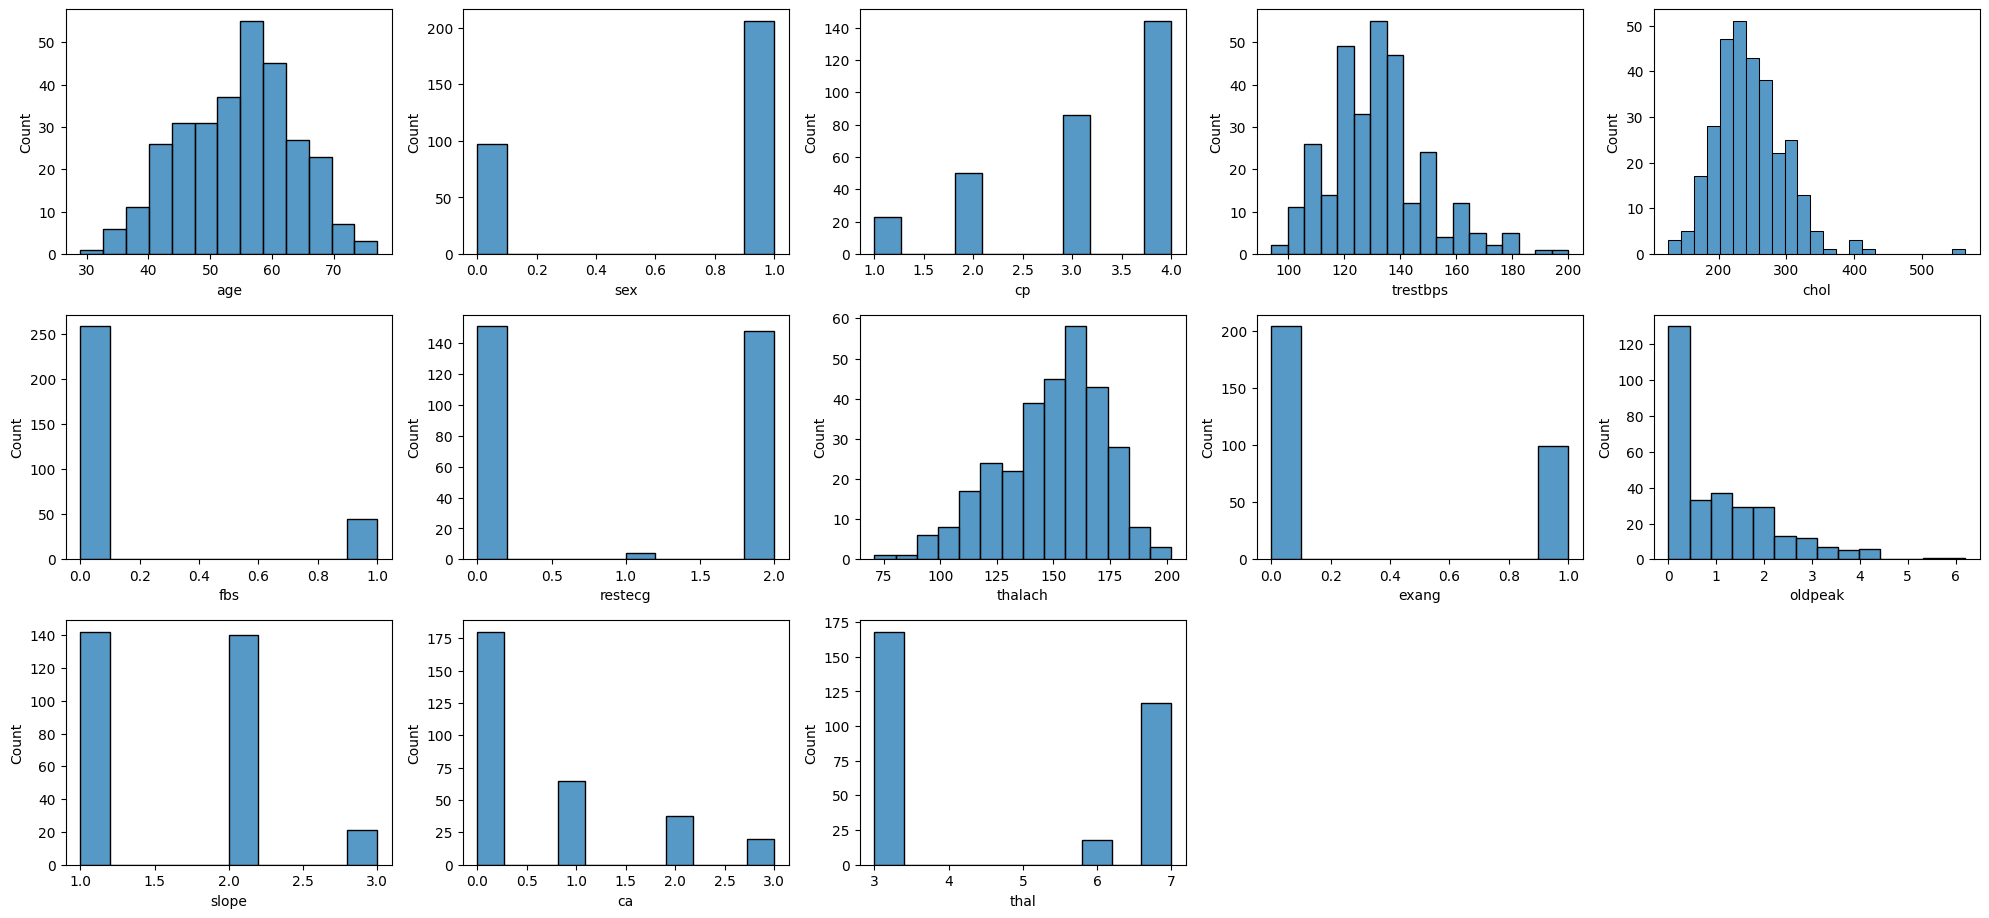

In [115]:
# Rysowanie wykresów wszystkich zmiennych objaśniających
plt.figure(figsize=(20,15))
# data['trestbps'] = np.log(data['trestbps'])
# data['chol'] = np.log(data['chol'])
# data['thalach'] = np.log(data['thalach'])
# data['oldpeak'] = np.log(data['oldpeak'].astype('float64')) # Transformacje zmiennych inne niż one hot encoding nie przyniosły zamierzonych rezultatów
plotnumber=1
columns_X = data.columns.drop('num')
data_for_plot = data[columns_X]
for column in data_for_plot:
    if plotnumber <= 13:
        ax = plt.subplot(5,5, plotnumber)
        sns.histplot(data_for_plot[column])
        plt.xlabel(column)
    plotnumber+=1

plt.tight_layout()
plt.show()

Na powyższych wykresach widać, że zmienne cp (ból w klatce), restecg (wynik EKG w spoczynku), slope (nachylenie odcinka ST podczas ćwiczen), ca (liczba kolorowanych żył w fluoroskopii), thal (talsemia) to kategorie, które mogą zostać przekształcone przy użyciu kodowania One hot encoding. Ta operacja wpłynęła istotnie na jakość klasyfikacji.

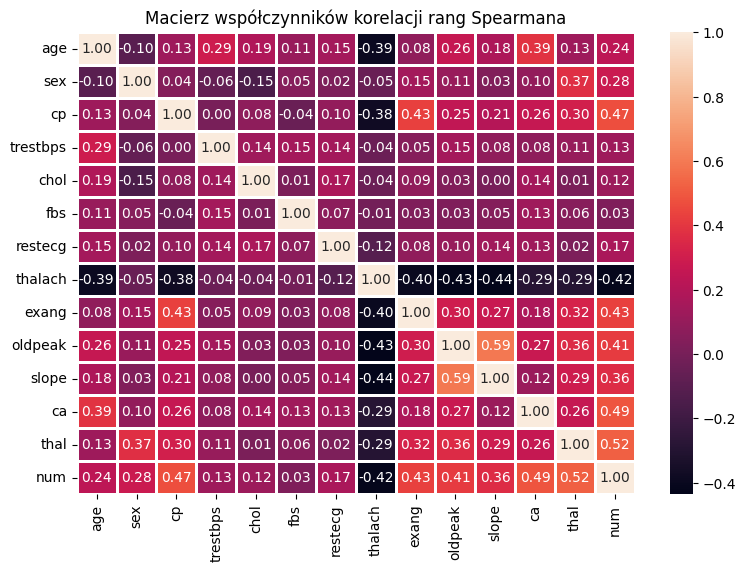

In [116]:
# Macierz korelacji rang spearmana
# numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns # Wszystkie wartości są numeryczne, fragment niepotrzebny

corr_matrix = data.corr('spearman')
# print("Correlation Matrix:\n", corr_matrix)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr_matrix, linewidths=1, annot=True, fmt = ".2f")
ax.set_title('Macierz współczynników korelacji rang Spearmana')
plt.show()

Macierz współczynników korelacji rang Spearmana pozwala stwierdzić, że wśród zmiennych objaśniających brak współliniowości, brak współczynników korelacji powyżej 0.7 lub poniżej -0.7.

In [117]:
# data.nunique()
# age          41
# sex           2
# cp            4
# trestbps     50
# chol        152
# fbs           2
# restecg       3
# thalach      91
# exang         2
# oldpeak      40
# slope         3
# ca            4
# thal          3
# num           2
# dtype: int64

#konwersja na kategorie zeby wyciagnac kategorie
data['cp'] = data['cp'].astype('category')
data['restecg'] = data['restecg'].astype('category')
data['slope'] = data['slope'].astype('category')
data['thal'] = data['thal'].astype('category')

#Dyskretyzacja wieku na ponizej 50, 50-59, 60+ lat - zmienne dyskretne sa nieistotne, wiec jednak nie dyskretyzuje zmiennej
# data['age_under50'] = (data['age'] < 50)
# data['age_50_59'] = ((data['age'] >= 50) & (data['age'] < 60))
# data['age_more60'] = (data['age'] >= 60)
# data = data.drop('age', axis = 1)
data = pd.get_dummies(data)

# Zamiana na integery wszystkich zmiennych poza oldpeak
for col in data:
    if col != 'oldpeak':
        data[col] = data[col].astype(int)

# tworze kopie zapasowa gotowego do pracy obiektu data
data_clean = data
data.describe()



,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,num,...,cp_4,restecg_0,restecg_1,restecg_2,slope_1,slope_2,slope_3,thal_3,thal_6,thal_7
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,131.689769,246.693069,0.148515,149.607261,0.326733,1.039604,0.663366,0.458746,...,0.475248,0.498350,0.013201,0.488449,0.468647,0.462046,0.069307,0.554455,0.059406,0.386139
std,9.038662,0.467299,17.599748,51.776918,0.356198,22.875003,0.469794,1.161075,0.934375,0.499120,...,0.500213,0.500824,0.114325,0.500693,0.499842,0.499382,0.254395,0.497848,0.236774,0.487668
min,29.000000,0.000000,94.000000,126.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,120.000000,211.000000,0.000000,133.500000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,130.000000,241.000000,0.000000,153.000000,0.000000,0.800000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,61.000000,1.000000,140.000000,275.000000,0.000000,166.000000,1.000000,1.600000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,77.000000,1.000000,200.000000,564.000000,1.000000,202.000000,1.000000,6.200000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Regresja Logistyczna

Pierwszy model przy użyciu którego będę prognozować prawdopodobieństwo choroby serca to model Logitowy. Skorzystałem z biblioteki statmodels ze względu na wygodny dostęp do oszacowań wpływu poszczególnych zmiennych i estetykę wydruku. Podczas procesu modelowania zmienne były przekształcane na różne sposoby oraz dokonanłem selekcji zmiennych. Poniższy dobór atrybutów warunkowych dał najlepszą jakość prognozy.
 
Dane zostały podzielone ze stratyfikacją na zbiór treningowy (75%) i testowy (25%). Większy zbiór testowy wynika z niewielkich różnic w wynikach miar jakości klasyfikacji. 


In [122]:
### model 1 - Regresja Logistyczna
#Wybieram zmienne niezależne / atrybuty warunkowe. 
#1. etap modelowania: Odrzucam zmienne ktore maja byc poziomem bazowym restecg_0 - ekg spoczynkowe w normie, thal_3 - talsemia w normie (brak), cp_4 - brak bolu w klatce, age_50_59 - wiek  50-59 lat 
#2. Wiek nieistotny - proba dyskretyzacji zakonczona niepowodzeniem - wszystkie poziomy nieistotne
#3. Odrzucenie zmiennych nieistotnych na kazdym sensownym poziomie istotnosci, kontrola potencjalnych confounderow 
        
#Ostateczny model logitowy - zmienne niezalezne z dodaniem stalej (X) i zmienna zalezna (y)

independent_vars = [col for col in data.columns if col not in ['num','restecg_0','thal_3','slope_2','cp_4', 'thal_6', 'slope_3', 'fbs', 'chol','age', 'restecg_1' ,'thalach' ]] #'age_more60', 'age_50_59'
y = data['num']
X = sm.add_constant(data[independent_vars])

#Podzial danych na zbior treningowy (75%) i testowy (25%) ze stratyfikacja po zmiennej objasnianej 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=144)


#Tworze model regresji logistycznej
model_logit = sm.Logit(y_train, X_train)
model_logit_final = model_logit.fit()

#Drukuje wyniki wraz z ilorazami szans oraz przedzialem ufnosci
print(model_logit_final.summary())
params = model_logit_final.params
conf = model_logit_final.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['5%', '95%', 'Odds Ratio']
print(np.exp(conf))

#Zapisuje predykcje prawdopodobienstwa i z przyjetym punktem odciecia 0.5 wersje binarna do uzycia w macierzy pomylek
y_pred_proba_logit = model_logit_final.predict(X_test)
y_pred_binary_logit = (y_pred_proba_logit > 0.5).astype(int)



Optimization terminated successfully.
         Current function value: 0.312357
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    num   No. Observations:                  227
Model:                          Logit   Df Residuals:                      215
Method:                           MLE   Df Model:                           11
Date:                Wed, 08 May 2024   Pseudo R-squ.:                  0.5471
Time:                        02:20:46   Log-Likelihood:                -70.905
converged:                       True   LL-Null:                       -156.55
Covariance Type:            nonrobust   LLR p-value:                 6.413e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5613      1.769     -2.578      0.010      -8.029      -1.093
sex            1.2877      0.

Zmienne istotne na każdym poziomie istotności to ca, cp_1, cp_3, thal_7. Na poziomie istotności 5% const(stała), płeć, oldpeak, cp_2. Na poziomie istotności 10% - exang, slope_1. Dla pozostałych zmiennych brak podstaw do odrzucenia hipotezy zerowej o nieistotności zmiennych. 

                      0  model
sensitivity    0.857143  Logit
specificity    0.878049  Logit
NPV            0.878049  Logit
PPV/precision  0.857143  Logit
f1_score       0.857143  Logit
accuracy       0.868421  Logit
FPR            0.121951  Logit
roc_auc        0.910105  Logit


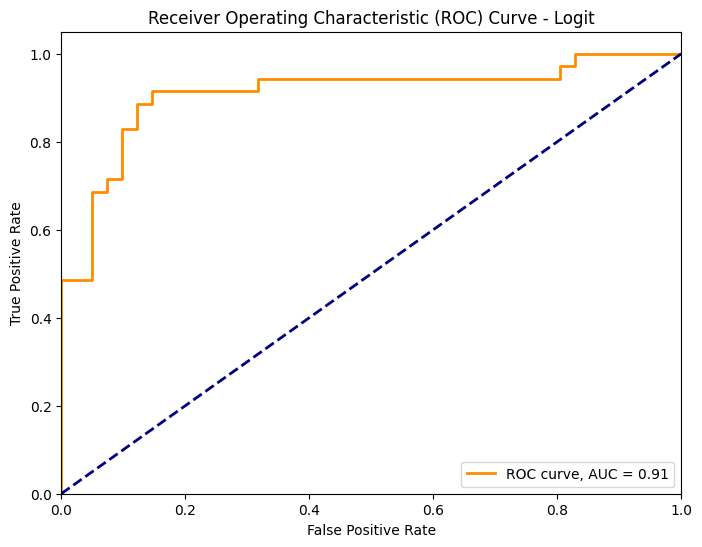

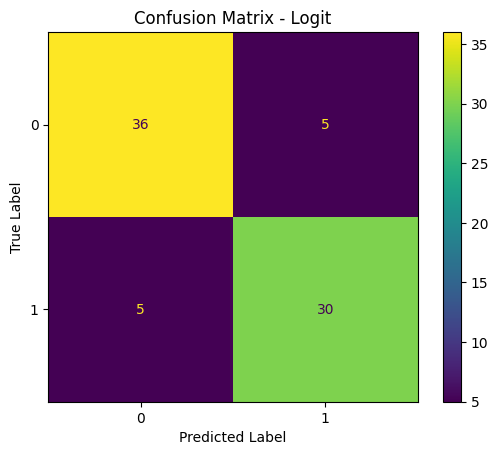

In [120]:
# Wydruk wynikow (jakosc prognozy)
metrics_logit = calculate_metrics(y_test, y_pred_binary_logit, y_pred_proba_logit, 'Logit')
print(metrics_logit)
plot_roc_curve(y_test,y_pred_proba_logit, name='Logit')
plot_confusion_matrix(y_test, y_pred_binary_logit, name='Logit')



Miary jakości klasyfikacji dla modelu Logitowego są następujące:
- wrażliwość: 0.857143,
- specificzność: 0.878049,
- precyzja: 0.857143,
- miara F1: 0.857143, 
- ujemna wartość predykcyjna: 0.878049,
- dokładność: 0.868421,
- współczynnik wyników fałszywie pozytywnych: 0.121951,
- auc: 0.910105

Model dobrze klasyfikuje osoby z chorobą serca oraz osoby bez choroby. na 41 obserwacji osób zdrowych, 5 zostało fałszywie zaklasyfikowanych jako osoby chore.
Spośród 35 osób chorych, 5 zostało błędnie zaklasyfikowanych jako osoby zdrowe. 

In [12]:
# Usuwam stala ze zbiorow:
X_train = X_train.drop('const', axis=1)
X_test = X_test.drop('const', axis=1)

## K Najbliższych Sąsiadów

Kolejnym użytym modelem jest KNN. W celu znalezienia najlepszego modelu użyłem losowego przeszukiwania siatki hiperparametrów.

 najlepsze hiperparametry KNN oszacowane przez algorytm random search: {'algorithm': 'auto', 'leaf_size': 48, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}
                      0 model
sensitivity    0.657143   KNN
specificity    0.878049   KNN
NPV            0.750000   KNN
PPV/precision  0.821429   KNN
f1_score       0.730159   KNN
accuracy       0.776316   KNN
FPR            0.121951   KNN
roc_auc        0.806620   KNN


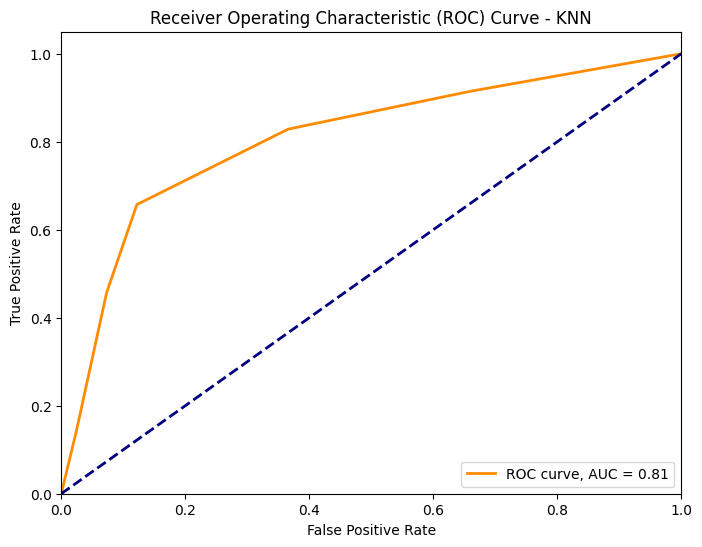

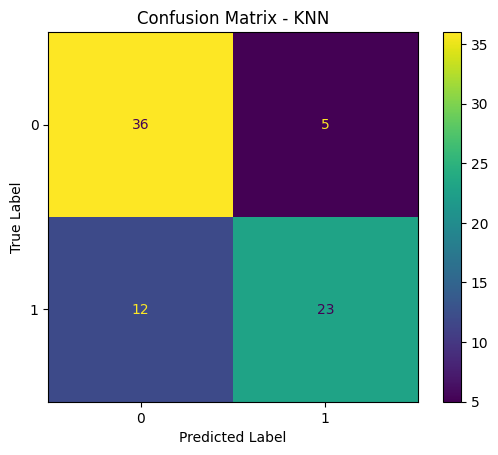

In [13]:
### model 2 - K Najblizszych Sasiadow

#Uzywam random search (losowe przeszukiwanie siatki) w celu znalezienia optymalnych parametrow modelu, definiuje w slowniku zakres losowego probkowania hiperparametrow
param_dist = {
    'n_neighbors': randint(1, 20),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': randint(10, 50),
    'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Definiuje klasyfikator dla wygody
knn = KNeighborsClassifier()

# Tworze obiekt przeszukujacy przestrzen hiperparametrow zdefiniowana w slowniku param_dist
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=200, cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# "Wyciagam" z obiektu random_search najlepiej dopasowany model
model_KNN_final = random_search.best_estimator_

# Zapisuje do oddzielnych obiektow prawdopodobienstwo zdyskretyzowane i z calego przedzialu[0;1]
y_pred_binary_KNN = model_KNN_final.predict(X_test)
y_pred_proba_KNN = model_KNN_final.predict_proba(X_test)[:,1]

# Wydruk wynikow
print(f" najlepsze hiperparametry KNN oszacowane przez algorytm random search: {random_search.best_params_}")
metrics_KNN = calculate_metrics(y_test, y_pred_binary_KNN, y_pred_proba_KNN, 'KNN')
print(metrics_KNN)
plot_roc_curve(y_test,y_pred_proba_KNN, 'KNN')
plot_confusion_matrix(y_test, y_pred_binary_KNN,labels = None, name =  'KNN')

Miary jakości klasyfikacji dla modelu KNN są następujące:
- wrażliwość: 0.657143,
- specificzność: 0.878049,
- precyzja: 0.821429,
- miara F1: 0.730159, 
- ujemna wartość predykcyjna: 0.750000,
- dokładność: 0.776316,
- współczynnik wyników fałszywie pozytywnych: 0.121951,
- auc: 0.806620

Model KNN jest znacznie gorszy od modelu Logitowego w rozróżnianiu osób chorych. Na 35 osób tylko 23 zostały poprawnie zaklasyfikowane jako chore.

## Las Losowy

Następny model to Las Losowy. Podobnie jak w przypadku KNN, zdefiniowałem siatkę do losowego przeszukania w poszukiwaniu najlepszych hiperparametrów poprzez random search 

c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Najwazniejsze zmienne wedlug funkcji SelectFromModel: ['sex', 'trestbps', 'exang', 'oldpeak', 'slope_1']
Najlepsze hiperparametry Random Forest:  {'bootstrap': True, 'criterion': 'log_loss', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 337}
                      0 model
sensitivity    0.800000    RF
specificity    0.853659    RF
NPV            0.833333    RF
PPV/precision  0.823529    RF
f1_score       0.811594    RF
accuracy       0.828947    RF
FPR            0.146341    RF
roc_auc        0.901045    RF


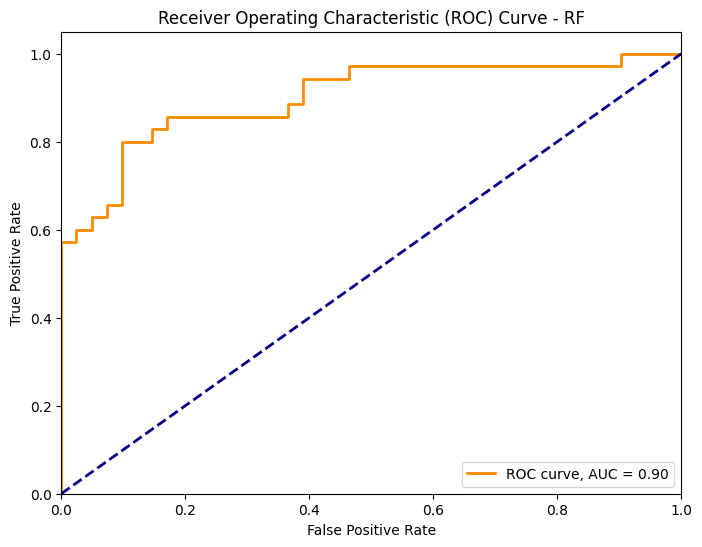

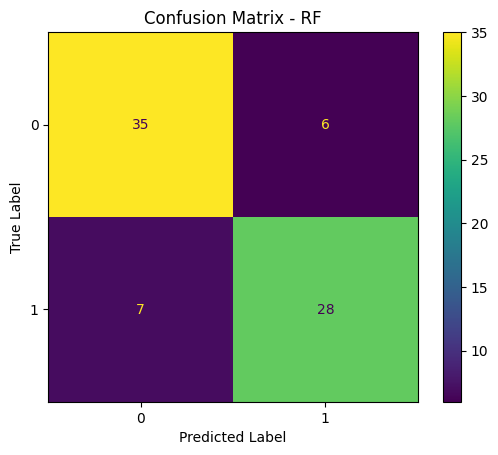

,Feature,Importance
0,oldpeak,0.191082
1,ca,0.168552
2,thal_7,0.142354
3,trestbps,0.112542
4,exang,0.098784
5,cp_3,0.079876
6,sex,0.058873
7,slope_1,0.055415
8,cp_1,0.034613
9,cp_2,0.029753


In [14]:
### model 3 - Random Forest
#Uzywam random search w celu znalezienia optymalnych parametrow modelu, definiuje w slowniku zakres losowego probkowania hiperparametrow
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

# Definiuje klasyfikator
rf = RandomForestClassifier(random_state=144)

# Tworze obiekt przeszukujacy przestrzen hiperparametrow zdefiniowana w slowniku param_dist
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', random_state=144, n_jobs=-1)
random_search.fit(X_train, y_train)

#"Wyciagam" z obiektu random_search najlepiej dopasowany model
model_RF_final = random_search.best_estimator_

# Uzywam funkcji SelectFromModel zeby wybrac najwazniejsze zmienne. Ograniczenie modelu tylko do nich skonczylo sie gorsza jakoscia prognozy
feature_selector = SelectFromModel(model_RF_final, prefit=True)
X_important_train = feature_selector.transform(X_train)
X_important_test = feature_selector.transform(X_test)

# Biore indeksy wybranych zmiennych
selected_feature_indices = feature_selector.get_support(indices=True)

# Przeszukuje te indeksy w poszukiwaniu nazw
selected_feature_names = [X.columns[i] for i in selected_feature_indices]

# Wydruk wynikow
print("Najwazniejsze zmienne wedlug funkcji SelectFromModel:", selected_feature_names)
print("Najlepsze hiperparametry Random Forest: ", random_search.best_params_)
y_pred_binary_rf = model_RF_final.predict(X_test)
y_pred_proba_rf = model_RF_final.predict_proba(X_test)[:, 1]
confusion_matrix(y_test,y_pred_binary_rf)
metrics_rf = calculate_metrics(y_test, y_pred_binary_rf, y_pred_proba_rf, 'RF')
print(metrics_rf)
plot_roc_curve(y_test,y_pred_proba_rf, 'RF')
plot_confusion_matrix(y_test, y_pred_binary_rf, labels = None, name = 'RF')
feature_importance(model_RF_final,X_train)

Miary jakości klasyfikacji modelu Lasu Losowego:
- wrażliwość: 0.800000,
- specificzność: 0.853659,
- precyzja: 0.823529,
- miara F1: 0.811594, 
- ujemna wartość predykcyjna: 0.833333,
- dokładność: 0.828947,
- współczynnik wyników fałszywie pozytywnych: 0.146341,
- auc: 0.901045

Las Losowy zdecydowanie lepiej klasyfikuje pacjentów do właściwych grup niż algorytm K Najbliższych Sąsiadów. Model cechuje się dużo wyższą wrażliwością, prawdopodobieństwem przewidzenia sukcesu dla
obserwacji, dla której zaobserwowano chorobę serca. Miara F1 również jest znacznie wyższa, jest to średnia harmoniczna precyzji i wrażliwości. Model przewidział poprawnie 28 z 35 przypadków osób chorych oraz 35 z 41 osób zdrowych.

## XGBoost

Następny model to eXtreme Gradient Boosting. W przypadku tego modelu testowałem grid search oraz random search. grid search liczył się około 20 minut, jednak lepsze wyniki otrzymałem z random search. W tej części będą przedstawione dwa modele XGBoost, jeden ze z góry zdefiniowanymi hiperparametrami, drugi przy użyciu metod przeszukiwania siatki hiperparametrów.

                      0         model
sensitivity    0.828571  XGB my param
specificity    0.878049  XGB my param
NPV            0.857143  XGB my param
PPV/precision  0.852941  XGB my param
f1_score       0.840580  XGB my param
accuracy       0.855263  XGB my param
FPR            0.121951  XGB my param
roc_auc        0.902439  XGB my param


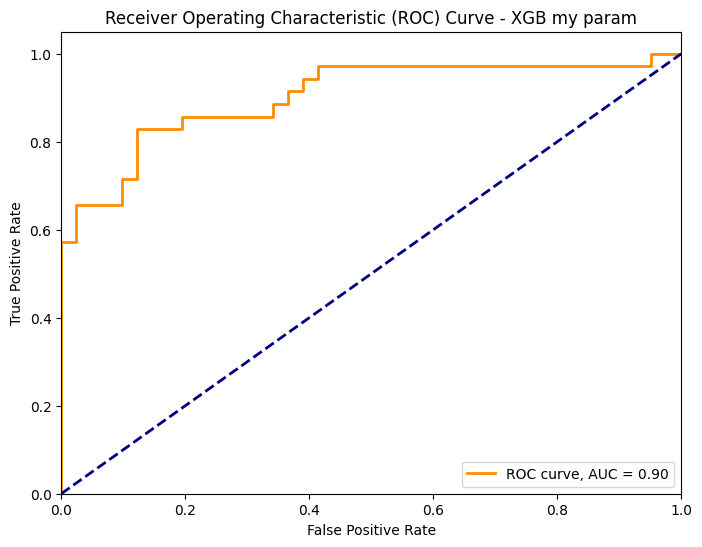

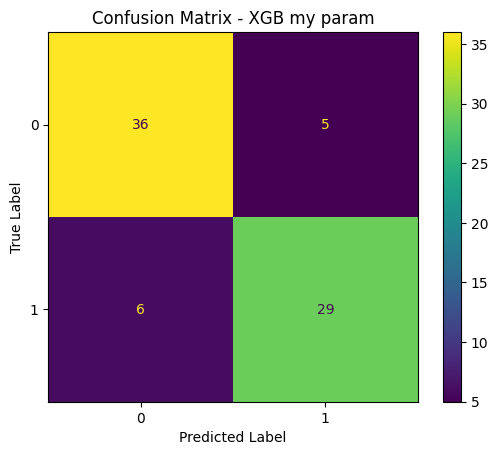

,Feature,Importance
0,thal_7,0.263218
1,ca,0.145862
2,exang,0.132284
3,cp_3,0.084878
4,sex,0.074992
5,cp_1,0.067557
6,oldpeak,0.064055
7,cp_2,0.057933
8,slope_1,0.053826
9,trestbps,0.031459


In [15]:
### model 4 - XGBoost
# Ekspercko definiuje hiperparametry do modelu
model_xgb = XGBClassifier(n_estimators=100, learning_rate=0.02, max_depth = 5,sampling_method = 'uniform',colsample_bytree = 0.7, subsample = 0.8, booster='gbtree', objective = 'binary:logistic', eval_metric = 'logloss', random_state=42)

# Uzywam metody .fit zeby dopasowac okreslony model do danych
model_xgb.fit(X_train, y_train)

# Zapisuje do oddzielnych obiektow prawdopodobienstwo zdyskretyzowane i z calego przedzialu[0;1]
y_pred_binary_xgb = model_xgb.predict(X_test)
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:,1]

# Wydruk wynikow
metrics_xgb_my_param= calculate_metrics(y_test, y_pred_binary_xgb, y_pred_proba_xgb, 'XGB my param')
print(metrics_xgb_my_param)
plot_roc_curve(y_test,y_pred_proba_xgb, 'XGB my param')
plot_confusion_matrix(y_test, y_pred_binary_xgb,labels = None, name =  'XGB my param')
feature_importance(model_xgb,X_train)

Miary jakości klasyfikacji dla modelu XGboost ze z góry ustalonymi hiperparametrami są następujące:
- wrażliwość: 0.828571,
- specificzność: 0.878049,
- precyzja: 0.852941,
- miara F1: 0.840580, 
- ujemna wartość predykcyjna: 0.857143,
- dokładność: 0.855263,
- współczynnik wyników fałszywie pozytywnych: 0.121951,
- auc: 0.902439

Model XGBoost z hiperparametrami ustalonymi z góry cechuje się bardzo zbliżoną dokładnością klasyfikacji do modelu Logitowego. Na próbce testowej tylko jedna chora osoba więcej niż w regresji Logistycznej została błędnie zaklasyfikowana jako zdrowa. Trudno powiedzieć który z nich okazałby się lepszy na większej próbie. Na 41 osób zdrowych  5 zostało zaklasyfikowanych jako chore, na 35 osób chorych 6 zostało błędnie zaklasyfikowane jako zdrowe.


### XGBoost Random Search

Poniżej przedstawiony został model XGBoost z zastosowaniem metody przeszukiwania siatki hiperparametrów.

Najlepsze hiperparametry XGBoost wedlug algorytmu random search: {'subsample': 0.7, 'sampling_method': 'uniform', 'objective': 'binary:logistic', 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'eval_metric': 'auc', 'colsample_bytree': 0.7, 'booster': 'gbtree'}
                      0 model
sensitivity    0.828571   XGB
specificity    0.853659   XGB
NPV            0.853659   XGB
PPV/precision  0.828571   XGB
f1_score       0.828571   XGB
accuracy       0.842105   XGB
FPR            0.146341   XGB
roc_auc        0.903833   XGB


c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
270 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\xgboost\core.py", line 730, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Bajdz\anaconda3\envs\py3117\Lib\site-packages\xgboost\sklearn.py", line 1519, in fit
    self._Booster = train(
  

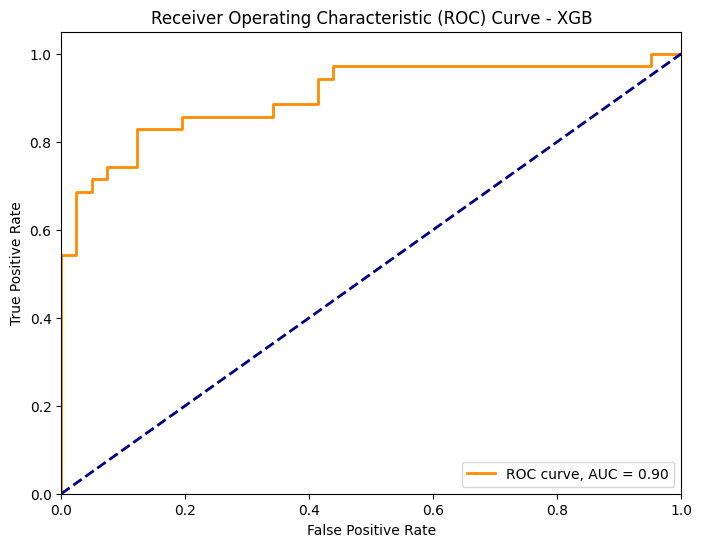

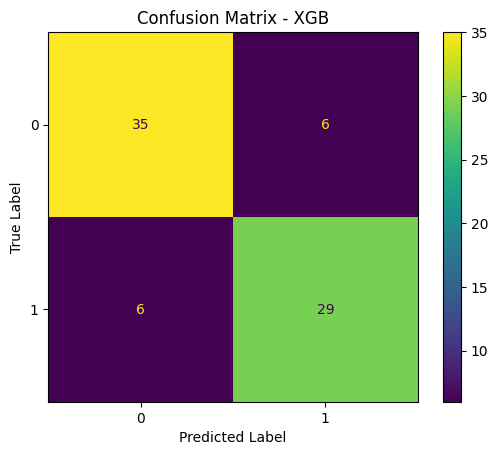

,Feature,Importance
0,thal_7,0.270818
1,ca,0.153606
2,exang,0.150061
3,sex,0.070363
4,oldpeak,0.065749
5,cp_3,0.064832
6,cp_1,0.060748
7,slope_1,0.056848
8,cp_2,0.052670
9,trestbps,0.030775


In [16]:
### model 4.1 - XGBoost - random search (losowe przeszukiwanie siatki), optymalizacja hiperparametrow

#Definiuje siatke hiperparametrow, metod optymalizacyjnych, miary ewaluacyjne
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': range(3, 10),
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.04, 0.08],
    'subsample': np.linspace(0.5, 0.95, 10),
    'colsample_bytree': np.linspace(0.5, 0.95, 10),
    'sampling_method': ['uniform', 'gradient_based'],
    'booster': ['gbtree', 'dart'],
    'objective': ['binary:logistic'],
    'eval_metric': ['logloss', 'auc'],
    
}

# Definiuje klasyfikator
xgb = XGBClassifier(random_state=42)

# Tworze obiekt randomsearch i uzywam metody .fit do danych treningowych
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=5, scoring='roc_auc', n_jobs=-1, n_iter=100, random_state=42)
random_search.fit(X_train, y_train)

# Wyciagam najlepszy model
model_xgb_final = random_search.best_estimator_


y_pred_binary_xgb_random = model_xgb_final.predict(X_test)
y_pred_proba_xgb_random = model_xgb_final.predict_proba(X_test)[:, 1]

#grid search (metoda przeszukiwania siatki), optymalizacja hiperparametrow [bardzo dlugo sie liczy, lepsze rozwiazanie z random search]
# # Definiuje siatke hiperparametrow
# param_grid = {
#     'n_estimators': [100, 200],
#     'max_depth': [4, 5, 6, 7],
#     'learning_rate': [0.005,0.01, 0.02, 0.04],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.85],
#     'sampling_method': ['uniform', 'gradient_based'],
#     'booster': ['gbtree', 'dart'],
#     'objective': ['binary:logistic'],
#     'eval_metric': ['logloss', 'auc']
# }

# # Definiuje klasyfikator
# xgb = XGBClassifier(random_state=42)

# # Tworze obiekt do przeszukania siatki a nastepnie uzywam metody .fit do danych treningowych
# grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Wyciagam najlepszy model
# model_xgb_final = grid_search.best_estimator_

# y_pred_binary_xgb_grid = model_xgb_final.predict(X_test)
# y_pred_proba_xgb_grid = model_xgb_final.predict_proba(X_test)[:, 1]

print(f"Najlepsze hiperparametry XGBoost wedlug algorytmu random search: {random_search.best_params_}")
metrics_xgb_random = calculate_metrics(y_test, y_pred_binary_xgb_random, y_pred_proba_xgb_random, 'XGB')
print(metrics_xgb_random)
plot_roc_curve(y_test, y_pred_proba_xgb_random, 'XGB')
plot_confusion_matrix(y_test, y_pred_binary_xgb_random, labels=None, name='XGB')
feature_importance(model_xgb_final,X_train)

Miary jakości klasyfikacji modelu XGBoost z użyciem losowego przeszukiwania siatki hiperparametrów:
- wrażliwość: 0.828571,
- specificzność: 0.853659,
- precyzja: 0.828571,
- miara F1: 0.828571, 
- ujemna wartość predykcyjna: 0.853659,
- dokładność: 0.842105,
- współczynnik wyników fałszywie pozytywnych: 0.146341,
- auc: 0.903833



Model XGBoost którego hiperparametry zostały dobrane na podstawie losowego przeszukania siatki również cechuje się dobrą dokładnością klasyfikacji. Miary klasyfikacji wskazują, że model jest nieznacznie gorszy od modelu Logitowego (1 więcej przypadek fałszywie dodatni i 1 przypadek fałszywie ujemny) oraz modelu XGBoost z narzuconymi hiperparametrami (o 1 przypadek fałszywie dodatni więcej). Oszacowanie pola pod krzywą ROC to jedyna z badanych miar, która okazała się być lepszą od pierwszego modelu XGboost. Na 41 osób zdrowych 6 zostało zaklasyfikowanych jako chore, na 35 osób chorych 6 zostało błędnie zaklasyfikowane jako zdrowe.

## Podsumowanie

Modele zostały oszacowane a miary jakości klasyfikacji opisane. Na koniec zostaną przedstawione najlepsze wyniki miar jakości. Na każdym etapie modelowania wyniki były zapisywane do odzielnych ramek danych. Czas je połączyć i upewnić się, który model jest najlepszy w klasyfikowaniu osób zdrowych i obciążonych chorobą serca.

In [17]:
# Lacze wszystkie miary do jednego data frame i robie reset index, zeby moc latwo operowac na kolumnach
all_used_models_metrics = pd.concat([metrics_logit, metrics_KNN, metrics_rf, metrics_xgb_my_param,metrics_xgb_random]).reset_index()
all_used_models_metrics = all_used_models_metrics.rename(columns={'index': 'metric', 0: 'value'})

In [18]:
# Sortuje po miarach i wartosciach, kwestie FPR rozwiaze pozniej
sorted_metrics = all_used_models_metrics.sort_values(by=['metric', 'value'], ascending=[True, False])

# Tworze slownik zeby zbierac informacje o miarach jakosci prognozy
best_metrics = {}

# Petla przechodzaca przez kazda unikalna wartosc w kolumnie miar, jezeli miara to nie FPR, to bierz pierwsza wartosc, w przeciwnym razie wez ostatnia
for metric, group in sorted_metrics.groupby('metric'):
    best_value = group['value'].iloc[0] if metric != 'FPR' else group['value'].iloc[-1]
    best_models = group[group['value'] == best_value]
    best_metrics[metric] = best_models

print("Najwyzsze wyniki poszczegolnych miar:")

# Drukuje dla kazdej miary najlepsze wyniki
for metric, best_model_group in best_metrics.items():
    print(f"{best_model_group} \n")

# Zliczam ile wynikow bylo najlepszych w celu okreslenia ktory model jest najlepiej dopasowany do danych testowych
best_metrics_count = pd.concat(best_metrics.values())['model'].value_counts()
print("\nIle najlepszych miar jakosci prognozy:")
print(best_metrics_count)

Najwyzsze wyniki poszczegolnych miar:
   metric     value         model
6     FPR  0.121951         Logit
14    FPR  0.121951           KNN
30    FPR  0.121951  XGB my param 

  metric     value  model
2    NPV  0.878049  Logit 

          metric     value  model
3  PPV/precision  0.857143  Logit 

     metric     value  model
5  accuracy  0.868421  Logit 

     metric     value  model
4  f1_score  0.857143  Logit 

    metric     value  model
7  roc_auc  0.910105  Logit 

        metric     value  model
0  sensitivity  0.857143  Logit 

         metric     value         model
1   specificity  0.878049         Logit
9   specificity  0.878049           KNN
25  specificity  0.878049  XGB my param 


Ile najlepszych miar jakosci prognozy:
model
Logit           8
KNN             2
XGB my param    2
Name: count, dtype: int64


Na powyższym wydruku zostały przedstawione najwyższe wyniki poszczególnych miar oraz zliczone w celu szybkiej oceny. W niniejszej analizie aż 8 miar jakości klasyfikacji (wszystkie z wybranych) są najlepsze dla modelu Logitowego. Równie dobre miary specyficzności i współczynnika wartości fałszywie pozytywnych mają modele KNN i XGBoost ze z góry ustalonymi hiperparametrami. Znając pozostałe wyniki można stwierdzić, że model XGBoost okazał się drugim najlepszym wyborem, KNN inne miary jakości miał najgorsze ze wszystkich.  
Podsumowując ranking oszacowanych modeli jest następujący:
1. model Logitowy
2. model XGBoost ze z góry ustalonymi hiperparametrami
3. model XGBoost z użyciem Random Search
4. model Random Forest z użyciem Random Search
5. model KNN z użyciem Random Search